In [5]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from torch.distributions import Normal
import random
import time
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

#####################  hyper parameters  ####################

MAX_EPISODES = 2001              
MAX_EP_STEPS = 60               

RENDER = False

LOAD_MEM = False
LOAD_MODEL = True
LOAD_FOLDER_NAME = 'carbinet_SELF_level_12789_4000+2000EPS'

LOAD_PRETRAIN = False

CHECK_POINT_EPI = 50


ENV_NAME = 'OpenCabinetDrawer-v0'       
SEED = 123                      

var = 5
var_low_bound = 0.05



In [6]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,hidden_dim):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.hidden_dim = hidden_dim
        self.pointer = 0                                                                         # exp buffer指针
        self.lr_a = 0.001                                                                      # learning rate for actor
        self.lr_c = 0.001                                                                       # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.001                                                                          # 软更新比例
        self.memory_capacity = 10000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        self.Success_record = np.zeros(MAX_EPISODES)
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound,hidden_size):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                
                self.linear1 = nn.Linear(s_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear4 = nn.Linear(hidden_size, a_dim)
                
                
                self.linear4.weight.data.uniform_(-0.03, 0.03)
                self.linear4.bias.data.uniform_(-0.03, 0.03)
#                 self.fc1 = nn.Linear(s_dim,256)
#                 self.fc1.weight.data.normal_(0,0.1)          # initialization
                
#                 self.fc2 = nn.Linear(256,512)
#                 self.fc2.weight.data.normal_(0,0.1)
#                                
#                 self.fc3 = nn.Linear(512,256)
#                 self.fc3.weight.data.normal_(0,0.1)
                
#                 self.out = nn.Linear(256,a_dim)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = F.relu(self.linear3(x))
                x = F.tanh(self.linear4(x))
                
#                 x = self.fc1(x)
#                 x = F.relu(x)
#                  
#                 x = self.fc2(x)
#                 x = F.relu(x)
                
#                 x = self.fc3(x)
#                 x = F.relu(x)
                
#                 x = self.out(x)
#                 x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim,hidden_size):
                super(CNet,self).__init__()
                
                self.linear1 = nn.Linear(s_dim + a_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
#                 self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, 1)
                

                self.linear3.weight.data.uniform_(-0.03,0.03)
                self.linear3.bias.data.uniform_(-0.03,0.03)

#                 self.fcs1 = nn.Linear(s_dim,256)
#                 self.fcs1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs2 = nn.Linear(256,512)
#                 self.fcs2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs3 = nn.Linear(512,256)
#                 self.fcs3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01) 
                
#                 self.fca1 = nn.Linear(a_dim,256)
#                 self.fca1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fca2 = nn.Linear(256,512)
#                 self.fca2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)              
                
#                 self.fca3 = nn.Linear(512,256)
#                 self.fca3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.out = nn.Linear(256,1)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
            def forward(self,s,a):
        
                x = torch.cat([s, a], 1)
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
#                 x = F.relu(self.linear3(x))
                x = self.linear3(x)

#                 x = self.fcs1(s)                              # 输入状态
#                 x = F.relu(x)
                
#                 x = self.fcs2(x)
#                 x = F.relu(x)
                
#                 x = self.fcs3(x)
#                 x = F.relu(x) 
                
#                 y = self.fca1(a)                              # 输入动作
#                 y = F.relu(y)
                
#                 y = self.fca2(y)                              
#                 y = F.relu(y)
                
#                 y = self.fca3(y)                              
#                 y = F.relu(y)
                
#                 net = F.relu(x+y)
#                 actions_value = self.out(net)                # 给出V(s,a)
                return x

        self.Actor_eval = ANet(s_dim, a_dim, a_bound, hidden_dim)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound, hidden_dim)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim,hidden_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim,hidden_dim)              # 当前网络
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)

        return self.Actor_eval(s)[0].detach()                

    def learn(self):
        #self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = lr_a)  # actor的优化器
        #self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = lr_c) # critic的优化器
        for x in self.Actor_target.state_dict().keys():#更新target network
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state
        
        
        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  

        loss_a = -torch.mean(q)            
        #print('q: ',q)
        #print('loss_a: ',loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()
        
        
        a_ = self.Actor_target(bs_)      
        q_ = self.Critic_target(bs_,a_)  
        q_target = br + self.gamma * q_  

        q_v = self.Critic_eval(bs,ba)

        td_error = self.loss_td(q_target,q_v)

        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()
        
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                              
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def Record_success(self,epi):
        self.Success_record[epi] = 1
        
    def save(self,folder_name):
    
        if os.path.exists('./DPG model/' + folder_name):
            os.remove('./DPG model/' + folder_name)
            
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Success_record.csv'
        xml_df = pd.DataFrame(self.Success_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        plt.scatter(x, y)
        plt.savefig('./DPG model/' + folder_name + '/scatter.png')
        plt.plot(x, y)
        plt.savefig('./DPG model/' + folder_name + '/plot.png')
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)
        
    def load_pretrain(self):    
        ddpg.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_eval.eval()
        ddpg.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_target.eval() 
#         ddpg.Critic_eval.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_eval.eval()
#         ddpg.Critic_target.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_target.eval() 

Load network parameters of: carbinet_SELF_level_12789_4000+2000EPS
Episode: 0  Reward: 55 Explore: 0.10
SUCCESS
Episode: 1  Reward: 1477 Explore: 0.10
Episode: 2  Reward: 20 Explore: 0.10
Episode: 3  Reward: -4 Explore: 0.10
Episode: 4  Reward: -166 Explore: 0.10
Episode: 5  Reward: 14 Explore: 0.10
Episode: 6  Reward: 172 Explore: 0.10
Episode: 7  Reward: -4 Explore: 0.10
Episode: 8  Reward: 68 Explore: 0.10
Episode: 9  Reward: -54 Explore: 0.10
Episode: 10  Reward: -253 Explore: 0.10
Episode: 11  Reward: 39 Explore: 0.10
Episode: 12  Reward: -329 Explore: 0.10
Episode: 13  Reward: -163 Explore: 0.10
Episode: 14  Reward: -152 Explore: 0.10
Episode: 15  Reward: -222 Explore: 0.10
Episode: 16  Reward: -24 Explore: 0.10
Episode: 17  Reward: -18 Explore: 0.10
Episode: 18  Reward: -156 Explore: 0.10
Episode: 19  Reward: -175 Explore: 0.10
Episode: 20  Reward: -39 Explore: 0.10
Episode: 21  Reward: -321 Explore: 0.10
Episode: 22  Reward: 16 Explore: 0.10
Episode: 23  Reward: -282 Explore: 0

Episode: 201  Reward: 47 Explore: 0.05
Episode: 202  Reward: 18 Explore: 0.05
Episode: 203  Reward: -26 Explore: 0.05
SUCCESS
Episode: 204  Reward: 1534 Explore: 0.05
Episode: 205  Reward: -207 Explore: 0.05
Episode: 206  Reward: -231 Explore: 0.05
Episode: 207  Reward: -307 Explore: 0.05
Episode: 208  Reward: -170 Explore: 0.05
Episode: 209  Reward: -4 Explore: 0.05
Episode: 210  Reward: -128 Explore: 0.05
Episode: 211  Reward: -25 Explore: 0.05
Episode: 212  Reward: -219 Explore: 0.05
Episode: 213  Reward: 60 Explore: 0.05
Episode: 214  Reward: 25 Explore: 0.05
Episode: 215  Reward: -265 Explore: 0.05
Episode: 216  Reward: -139 Explore: 0.05
Episode: 217  Reward: -163 Explore: 0.05
Episode: 218  Reward: -91 Explore: 0.05
Episode: 219  Reward: -247 Explore: 0.05
SUCCESS
Episode: 220  Reward: 1082 Explore: 0.05
Episode: 221  Reward: -71 Explore: 0.05
Episode: 222  Reward: -154 Explore: 0.05
Episode: 223  Reward: -32 Explore: 0.05
Episode: 224  Reward: 59 Explore: 0.05
Episode: 225  Rew

Episode: 401  Reward: 13 Explore: 0.05
SUCCESS
Episode: 402  Reward: 1458 Explore: 0.05
SUCCESS
Episode: 403  Reward: 829 Explore: 0.05
Episode: 404  Reward: -295 Explore: 0.05
Episode: 405  Reward: 12 Explore: 0.05
Episode: 406  Reward: 29 Explore: 0.05
SUCCESS
Episode: 407  Reward: 1181 Explore: 0.05
Episode: 408  Reward: -315 Explore: 0.05
Episode: 409  Reward: 3 Explore: 0.05
Episode: 410  Reward: 47 Explore: 0.05
Episode: 411  Reward: 8 Explore: 0.05
Episode: 412  Reward: 77 Explore: 0.05
Episode: 413  Reward: 24 Explore: 0.05
Episode: 414  Reward: 29 Explore: 0.05
Episode: 415  Reward: -143 Explore: 0.05
Episode: 416  Reward: -445 Explore: 0.05
Episode: 417  Reward: 41 Explore: 0.05
Episode: 418  Reward: 32 Explore: 0.05
Episode: 419  Reward: -60 Explore: 0.05
Episode: 420  Reward: -31 Explore: 0.05
SUCCESS
Episode: 421  Reward: 1231 Explore: 0.05
Episode: 422  Reward: -41 Explore: 0.05
SUCCESS
Episode: 423  Reward: 999 Explore: 0.05
Episode: 424  Reward: -36 Explore: 0.05
Episod

Episode: 602  Reward: -136 Explore: 0.05
Episode: 603  Reward: -142 Explore: 0.05
Episode: 604  Reward: -73 Explore: 0.05
Episode: 605  Reward: -218 Explore: 0.05
Episode: 606  Reward: -80 Explore: 0.05
Episode: 607  Reward: -76 Explore: 0.05
Episode: 608  Reward: -127 Explore: 0.05
Episode: 609  Reward: 4 Explore: 0.05
Episode: 610  Reward: 2 Explore: 0.05
Episode: 611  Reward: -17 Explore: 0.05
Episode: 612  Reward: -16 Explore: 0.05
Episode: 613  Reward: 5 Explore: 0.05
Episode: 614  Reward: 16 Explore: 0.05
Episode: 615  Reward: 34 Explore: 0.05
Episode: 616  Reward: -132 Explore: 0.05
Episode: 617  Reward: -121 Explore: 0.05
SUCCESS
Episode: 618  Reward: 1457 Explore: 0.05
Episode: 619  Reward: -105 Explore: 0.05
SUCCESS
Episode: 620  Reward: 1194 Explore: 0.05
Episode: 621  Reward: -122 Explore: 0.05
Episode: 622  Reward: 81 Explore: 0.05
Episode: 623  Reward: -163 Explore: 0.05
Episode: 624  Reward: -191 Explore: 0.05
Episode: 625  Reward: 6 Explore: 0.05
Episode: 626  Reward: -

Episode: 804  Reward: -162 Explore: 0.05
Episode: 805  Reward: -1 Explore: 0.05
Episode: 806  Reward: -1 Explore: 0.05
Episode: 807  Reward: 12 Explore: 0.05
Episode: 808  Reward: -68 Explore: 0.05
Episode: 809  Reward: -27 Explore: 0.05
Episode: 810  Reward: -119 Explore: 0.05
Episode: 811  Reward: -7 Explore: 0.05
Episode: 812  Reward: -7 Explore: 0.05
SUCCESS
Episode: 813  Reward: 940 Explore: 0.05
Episode: 814  Reward: -53 Explore: 0.05
Episode: 815  Reward: -80 Explore: 0.05
Episode: 816  Reward: 200 Explore: 0.05
Episode: 817  Reward: -22 Explore: 0.05
Episode: 818  Reward: -107 Explore: 0.05
Episode: 819  Reward: -6 Explore: 0.05
Episode: 820  Reward: 28 Explore: 0.05
Episode: 821  Reward: 43 Explore: 0.05
Episode: 822  Reward: -426 Explore: 0.05
Episode: 823  Reward: -44 Explore: 0.05
Episode: 824  Reward: -44 Explore: 0.05
Episode: 825  Reward: -79 Explore: 0.05
Episode: 826  Reward: -10 Explore: 0.05
Episode: 827  Reward: -48 Explore: 0.05
SUCCESS
Episode: 828  Reward: 1326 E

Episode: 1006  Reward: -2 Explore: 0.05
Episode: 1007  Reward: -35 Explore: 0.05
Episode: 1008  Reward: -86 Explore: 0.05
Episode: 1009  Reward: -42 Explore: 0.05
Episode: 1010  Reward: -87 Explore: 0.05
Episode: 1011  Reward: -6 Explore: 0.05
Episode: 1012  Reward: 20 Explore: 0.05
SUCCESS
Episode: 1013  Reward: 689 Explore: 0.05
Episode: 1014  Reward: 14 Explore: 0.05
Episode: 1015  Reward: -48 Explore: 0.05
Episode: 1016  Reward: -37 Explore: 0.05
Episode: 1017  Reward: 62 Explore: 0.05
Episode: 1018  Reward: 70 Explore: 0.05
Episode: 1019  Reward: 95 Explore: 0.05
Episode: 1020  Reward: -38 Explore: 0.05
Episode: 1021  Reward: 36 Explore: 0.05
Episode: 1022  Reward: 50 Explore: 0.05
SUCCESS
Episode: 1023  Reward: 658 Explore: 0.05
Episode: 1024  Reward: -134 Explore: 0.05
Episode: 1025  Reward: 4 Explore: 0.05
Episode: 1026  Reward: -83 Explore: 0.05
Episode: 1027  Reward: -2 Explore: 0.05
Episode: 1028  Reward: 37 Explore: 0.05
Episode: 1029  Reward: 239 Explore: 0.05
Episode: 103

/tmp/ipykernel_3777/1934568889.py:234: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10), dpi=70)


SUCCESS
Episode: 1051  Reward: 647 Explore: 0.05
Episode: 1052  Reward: 51 Explore: 0.05
Episode: 1053  Reward: -115 Explore: 0.05
Episode: 1054  Reward: -39 Explore: 0.05
Episode: 1055  Reward: 11 Explore: 0.05
Episode: 1056  Reward: 525 Explore: 0.05
Episode: 1057  Reward: -8 Explore: 0.05
Episode: 1058  Reward: -32 Explore: 0.05
Episode: 1059  Reward: -48 Explore: 0.05
Episode: 1060  Reward: -83 Explore: 0.05
Episode: 1061  Reward: -36 Explore: 0.05
Episode: 1062  Reward: -129 Explore: 0.05
Episode: 1063  Reward: -8 Explore: 0.05
Episode: 1064  Reward: -6 Explore: 0.05
Episode: 1065  Reward: -132 Explore: 0.05
Episode: 1066  Reward: -37 Explore: 0.05
Episode: 1067  Reward: -33 Explore: 0.05
Episode: 1068  Reward: -43 Explore: 0.05
Episode: 1069  Reward: -158 Explore: 0.05
Episode: 1070  Reward: -13 Explore: 0.05
Episode: 1071  Reward: 25 Explore: 0.05
Episode: 1072  Reward: -16 Explore: 0.05
Episode: 1073  Reward: -191 Explore: 0.05
Episode: 1074  Reward: 46 Explore: 0.05
Episode: 1

SUCCESS
Episode: 1251  Reward: 1117 Explore: 0.05
Episode: 1252  Reward: 6 Explore: 0.05
Episode: 1253  Reward: -70 Explore: 0.05
Episode: 1254  Reward: -2 Explore: 0.05
Episode: 1255  Reward: -60 Explore: 0.05
SUCCESS
Episode: 1256  Reward: 1519 Explore: 0.05
Episode: 1257  Reward: -67 Explore: 0.05
Episode: 1258  Reward: -29 Explore: 0.05
Episode: 1259  Reward: -84 Explore: 0.05
Episode: 1260  Reward: -69 Explore: 0.05
Episode: 1261  Reward: 708 Explore: 0.05
Episode: 1262  Reward: -112 Explore: 0.05
Episode: 1263  Reward: -34 Explore: 0.05
Episode: 1264  Reward: 228 Explore: 0.05
Episode: 1265  Reward: -63 Explore: 0.05
Episode: 1266  Reward: -113 Explore: 0.05
Episode: 1267  Reward: -74 Explore: 0.05
Episode: 1268  Reward: 17 Explore: 0.05
Episode: 1269  Reward: 188 Explore: 0.05
Episode: 1270  Reward: 2 Explore: 0.05
Episode: 1271  Reward: -32 Explore: 0.05
SUCCESS
Episode: 1272  Reward: 1700 Explore: 0.05
Episode: 1273  Reward: 35 Explore: 0.05
Episode: 1274  Reward: -5 Explore: 

Episode: 1445  Reward: -133 Explore: 0.05
SUCCESS
Episode: 1446  Reward: 601 Explore: 0.05
Episode: 1447  Reward: -183 Explore: 0.05
SUCCESS
Episode: 1448  Reward: 1270 Explore: 0.05
Episode: 1449  Reward: -175 Explore: 0.05
SUCCESS
Episode: 1450  Reward: 837 Explore: 0.05
Episode: 1451  Reward: -135 Explore: 0.05
Episode: 1452  Reward: -142 Explore: 0.05
Episode: 1453  Reward: -139 Explore: 0.05
SUCCESS
Episode: 1454  Reward: 882 Explore: 0.05
SUCCESS
Episode: 1455  Reward: 961 Explore: 0.05
Episode: 1456  Reward: -39 Explore: 0.05
SUCCESS
Episode: 1457  Reward: 922 Explore: 0.05
Episode: 1458  Reward: 27 Explore: 0.05
Episode: 1459  Reward: -64 Explore: 0.05
Episode: 1460  Reward: -247 Explore: 0.05
Episode: 1461  Reward: -4 Explore: 0.05
Episode: 1462  Reward: 52 Explore: 0.05
Episode: 1463  Reward: -240 Explore: 0.05
Episode: 1464  Reward: 22 Explore: 0.05
Episode: 1465  Reward: 11 Explore: 0.05
Episode: 1466  Reward: 22 Explore: 0.05
Episode: 1467  Reward: 52 Explore: 0.05
SUCCESS

Episode: 1639  Reward: 40 Explore: 0.05
Episode: 1640  Reward: 152 Explore: 0.05
Episode: 1641  Reward: 37 Explore: 0.05
Episode: 1642  Reward: 21 Explore: 0.05
Episode: 1643  Reward: 31 Explore: 0.05
SUCCESS
Episode: 1644  Reward: 757 Explore: 0.05
SUCCESS
Episode: 1645  Reward: 693 Explore: 0.05
Episode: 1646  Reward: -3 Explore: 0.05
Episode: 1647  Reward: 25 Explore: 0.05
Episode: 1648  Reward: 87 Explore: 0.05
Episode: 1649  Reward: 65 Explore: 0.05
Episode: 1650  Reward: 52 Explore: 0.05
Episode: 1651  Reward: 2 Explore: 0.05
Episode: 1652  Reward: -26 Explore: 0.05
Episode: 1653  Reward: 24 Explore: 0.05
Episode: 1654  Reward: -42 Explore: 0.05
Episode: 1655  Reward: 31 Explore: 0.05
Episode: 1656  Reward: -15 Explore: 0.05
Episode: 1657  Reward: 138 Explore: 0.05
Episode: 1658  Reward: -60 Explore: 0.05
Episode: 1659  Reward: -46 Explore: 0.05
Episode: 1660  Reward: -71 Explore: 0.05
Episode: 1661  Reward: -72 Explore: 0.05
Episode: 1662  Reward: 9 Explore: 0.05
Episode: 1663  

SUCCESS
Episode: 1836  Reward: 1194 Explore: 0.05
Episode: 1837  Reward: -182 Explore: 0.05
Episode: 1838  Reward: -54 Explore: 0.05
Episode: 1839  Reward: -146 Explore: 0.05
Episode: 1840  Reward: -177 Explore: 0.05
Episode: 1841  Reward: -149 Explore: 0.05
Episode: 1842  Reward: -12 Explore: 0.05
Episode: 1843  Reward: -14 Explore: 0.05
Episode: 1844  Reward: -283 Explore: 0.05
Episode: 1845  Reward: -194 Explore: 0.05
Episode: 1846  Reward: -36 Explore: 0.05
Episode: 1847  Reward: -155 Explore: 0.05
SUCCESS
Episode: 1848  Reward: 1599 Explore: 0.05
Episode: 1849  Reward: 1 Explore: 0.05
Episode: 1850  Reward: -63 Explore: 0.05
Episode: 1851  Reward: -32 Explore: 0.05
Episode: 1852  Reward: -90 Explore: 0.05
Episode: 1853  Reward: -37 Explore: 0.05
Episode: 1854  Reward: 72 Explore: 0.05
Episode: 1855  Reward: 51 Explore: 0.05
Episode: 1856  Reward: 38 Explore: 0.05
Episode: 1857  Reward: 6 Explore: 0.05
SUCCESS
Episode: 1858  Reward: 1022 Explore: 0.05
Episode: 1859  Reward: -43 Exp

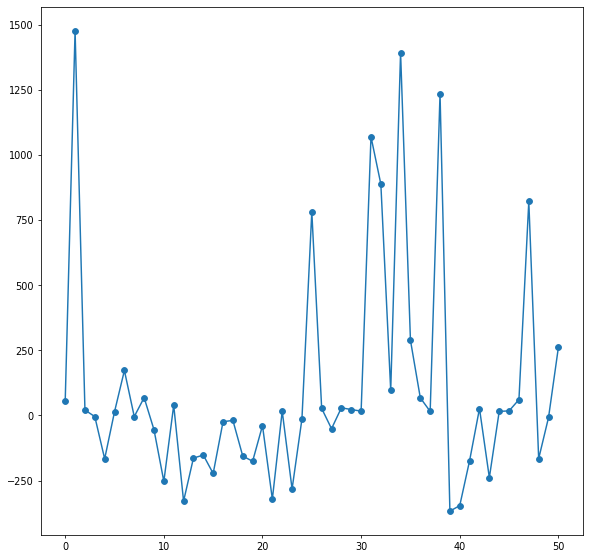

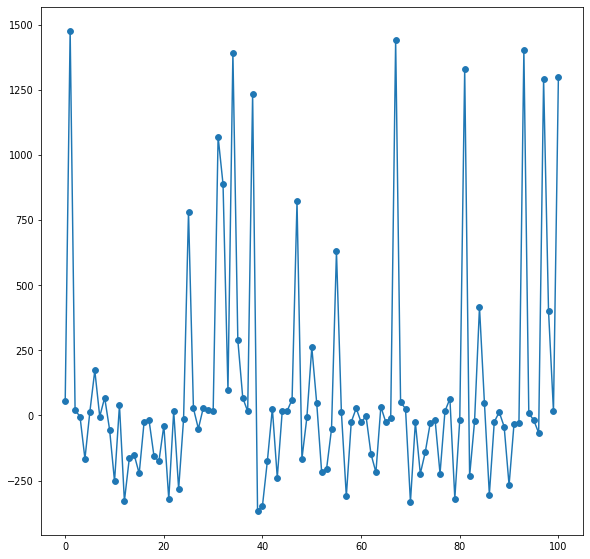

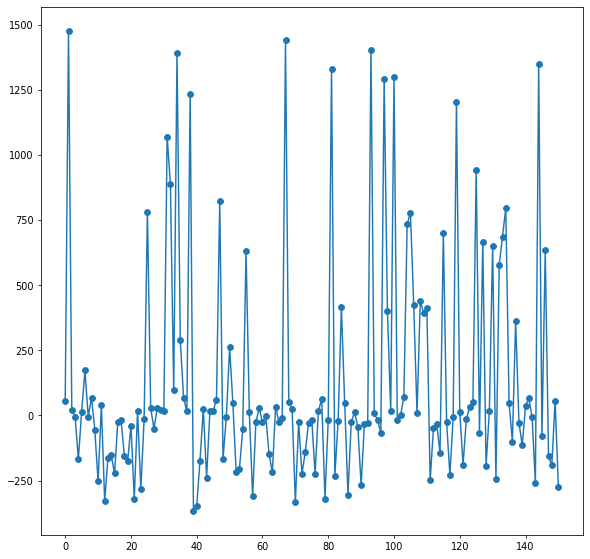

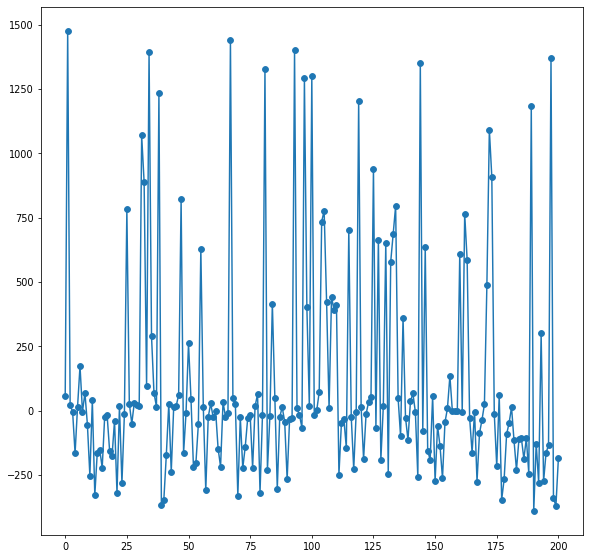

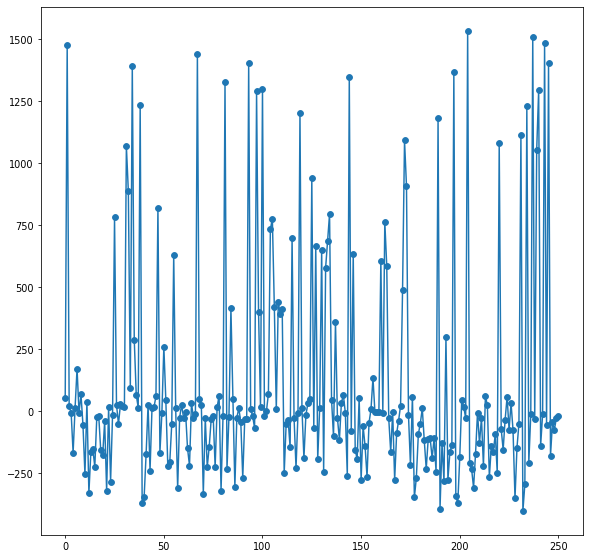

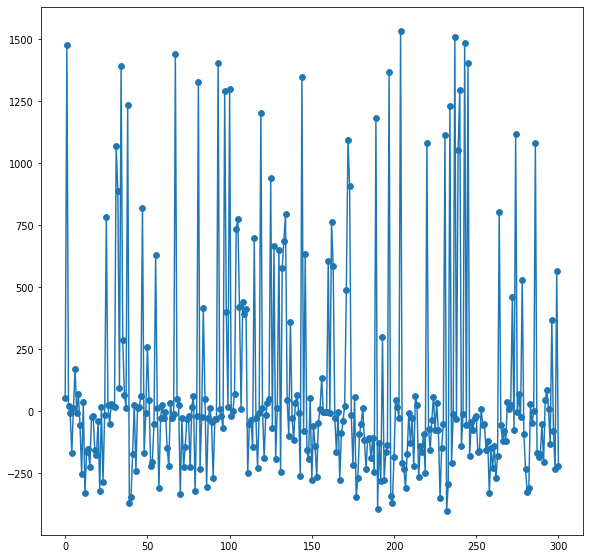

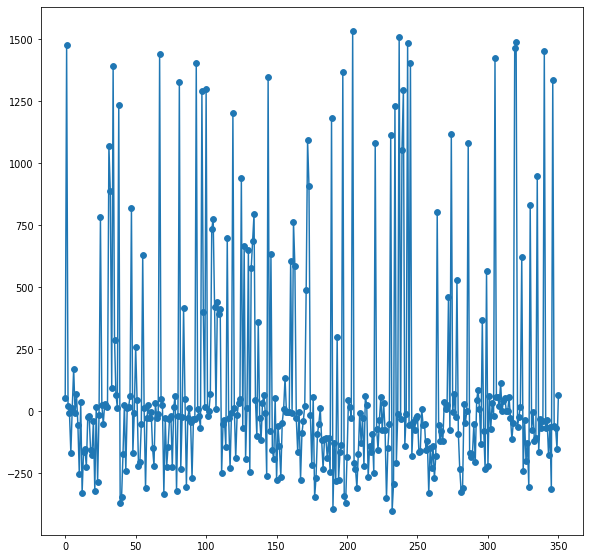

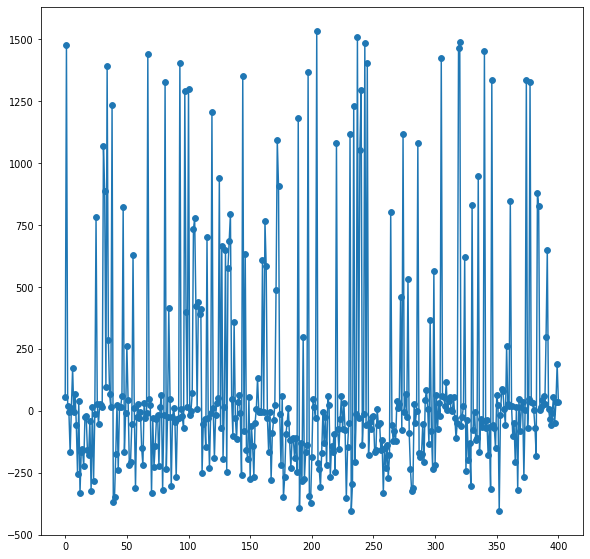

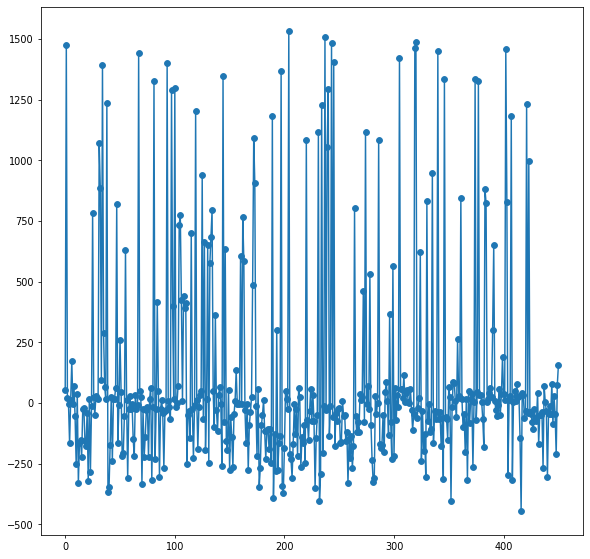

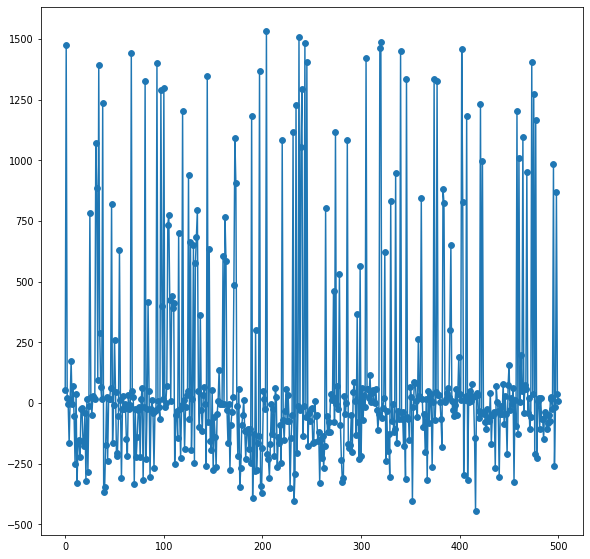

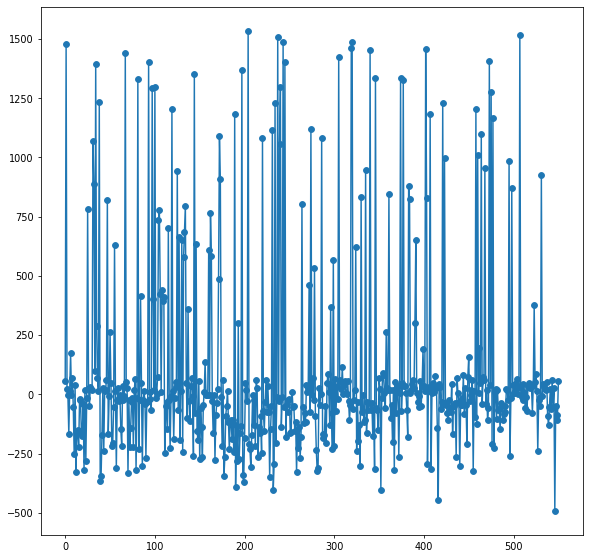

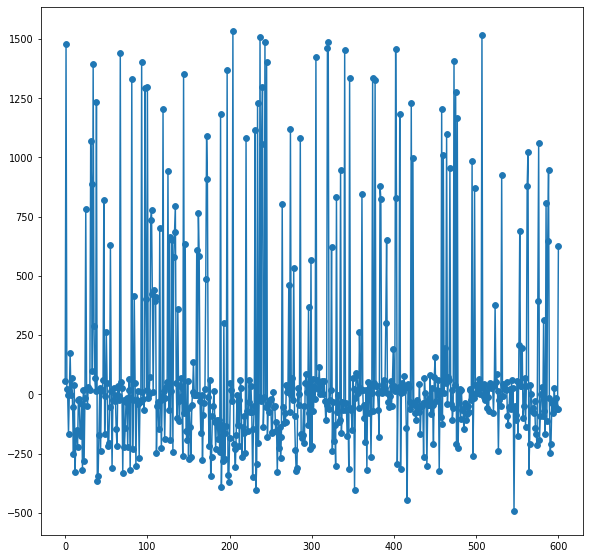

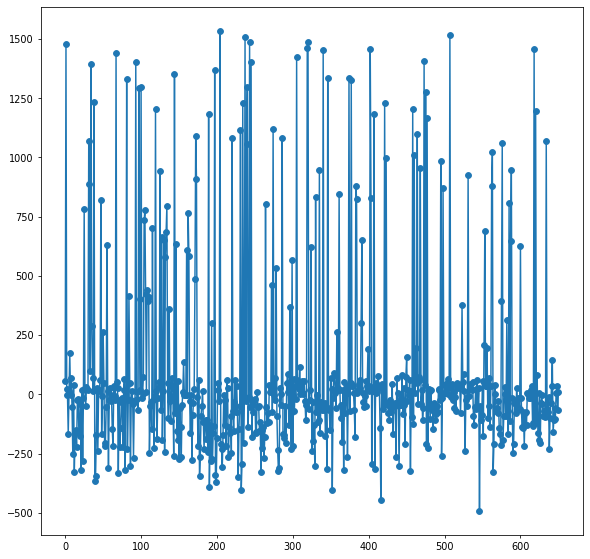

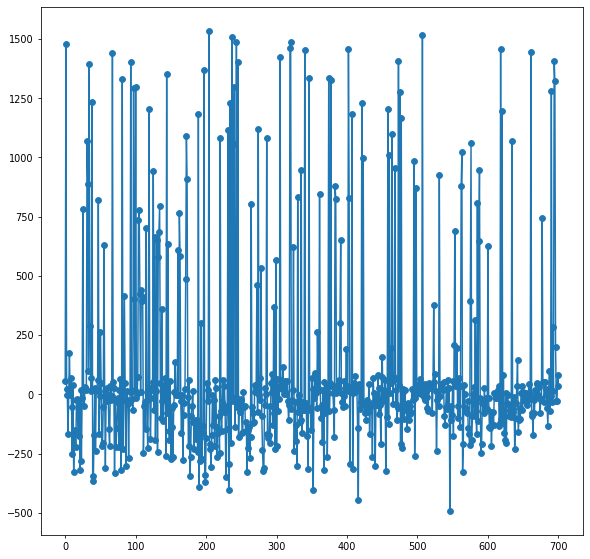

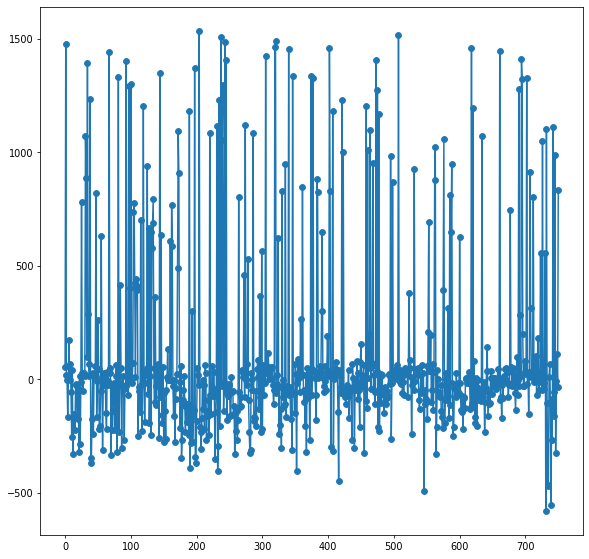

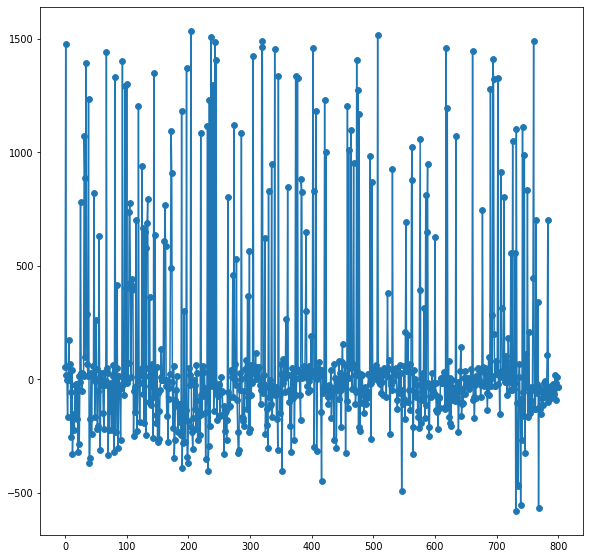

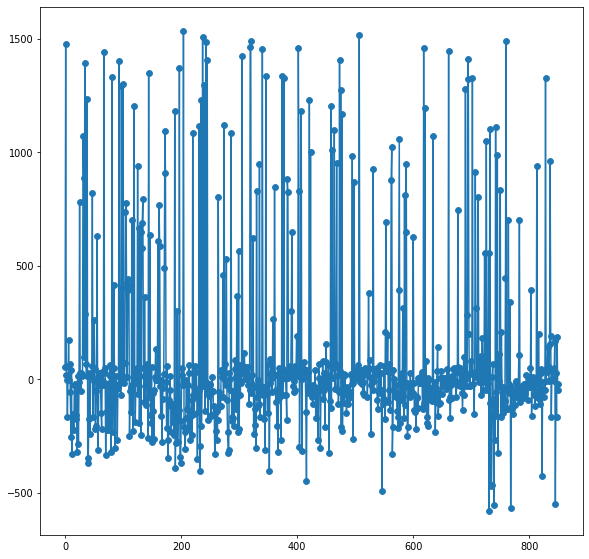

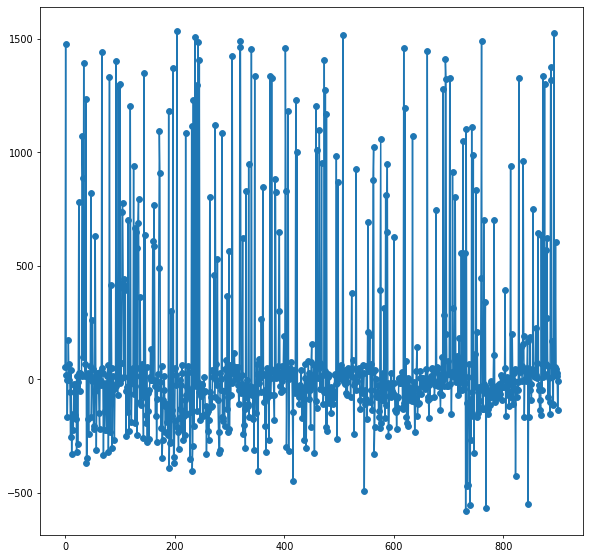

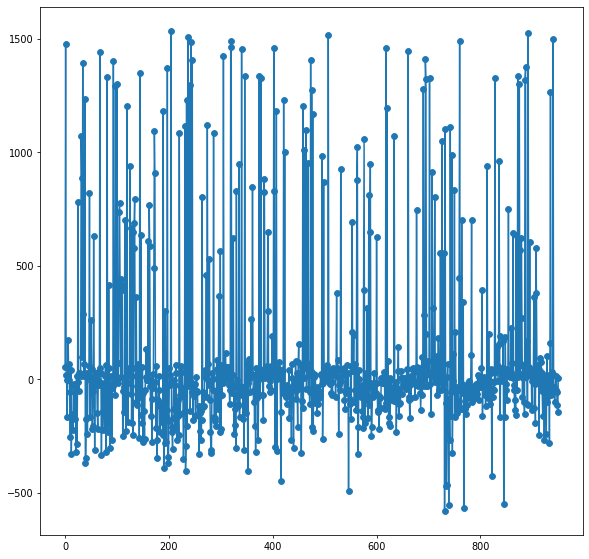

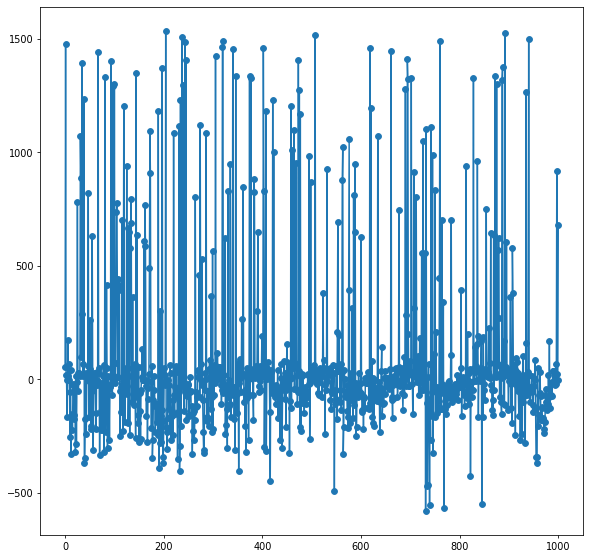

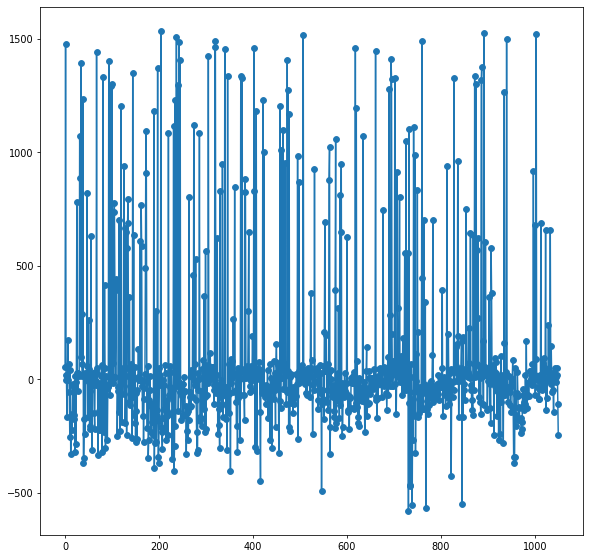

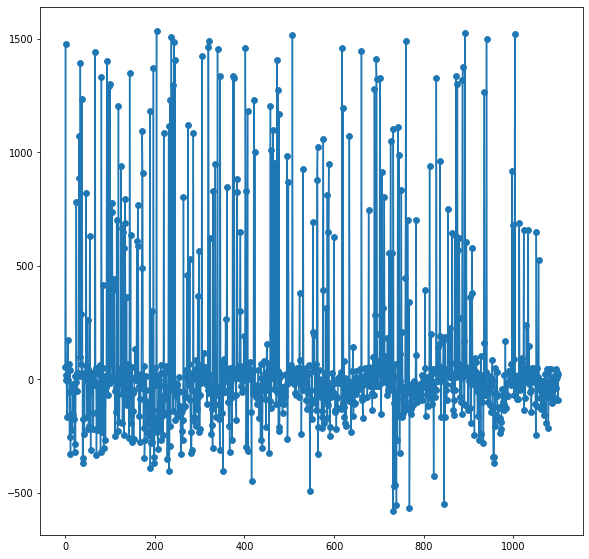

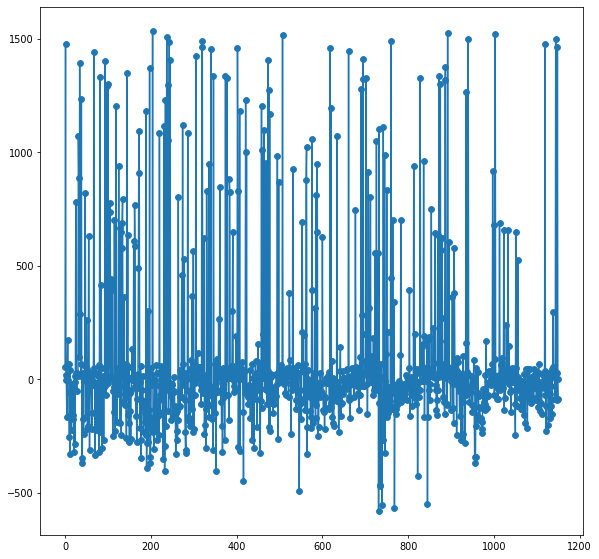

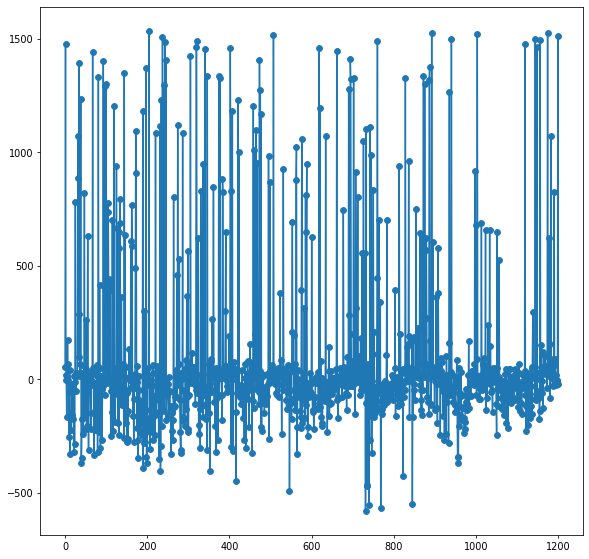

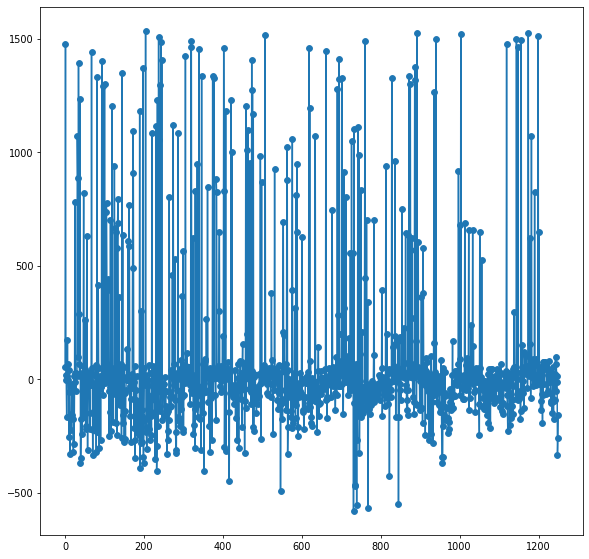

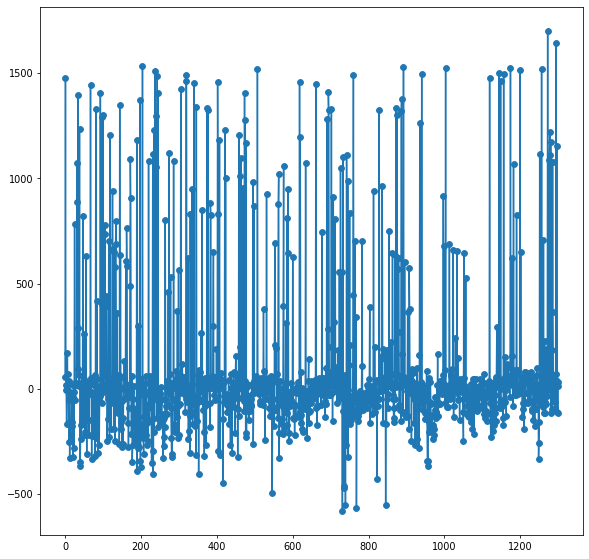

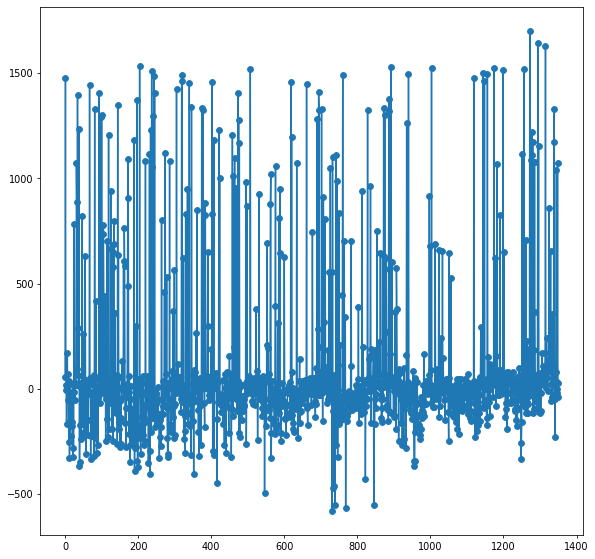

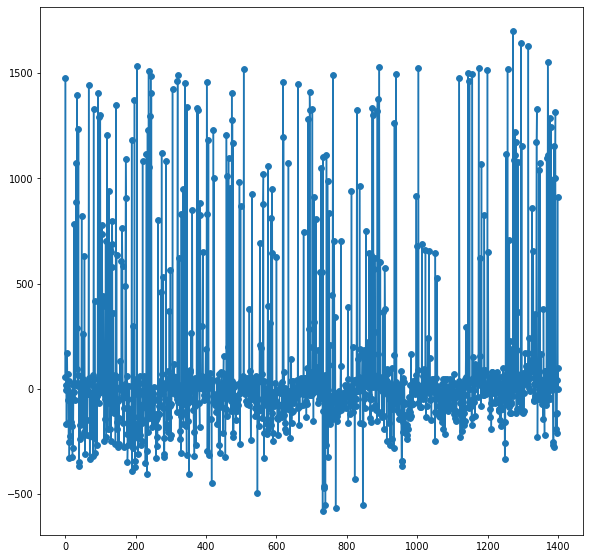

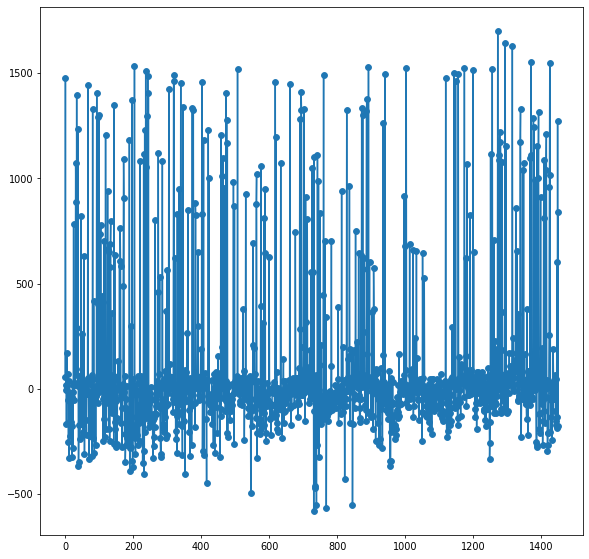

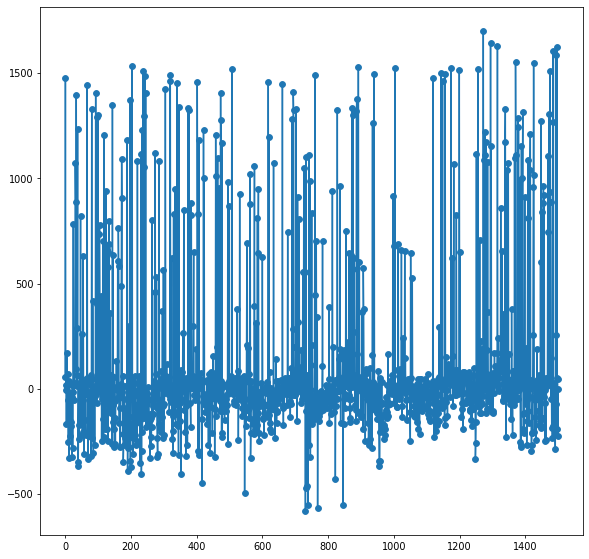

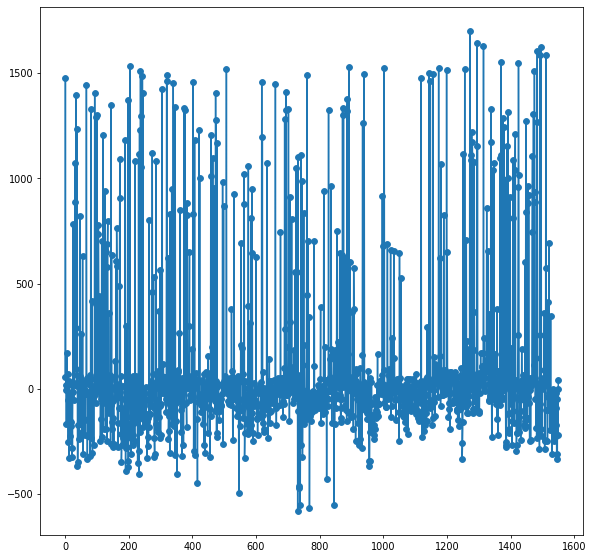

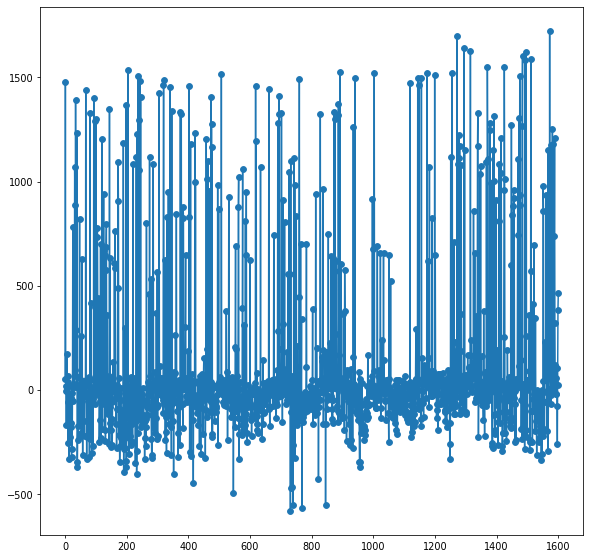

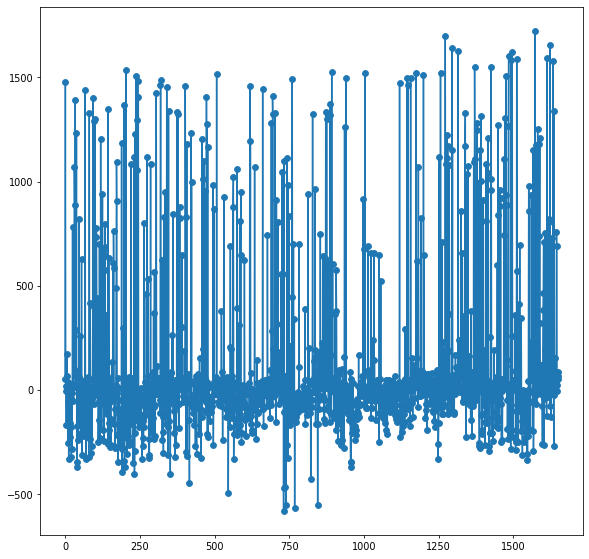

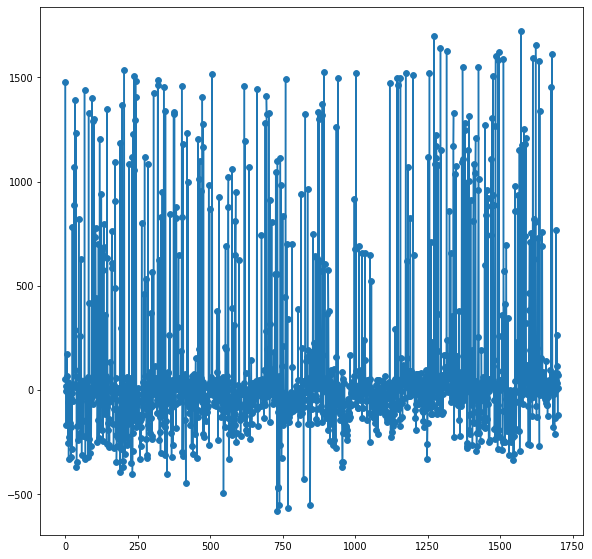

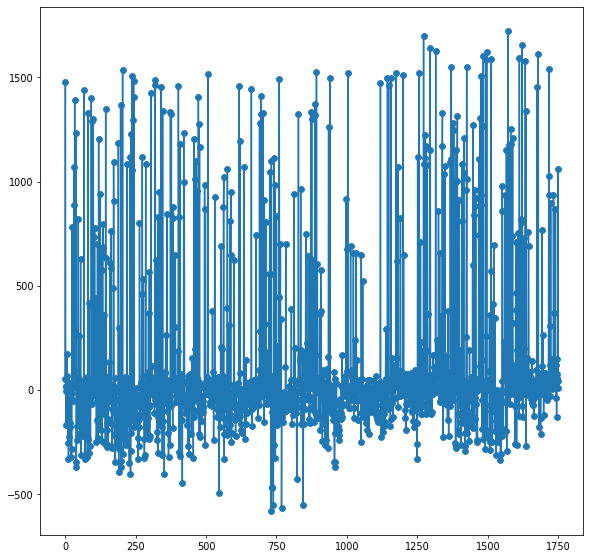

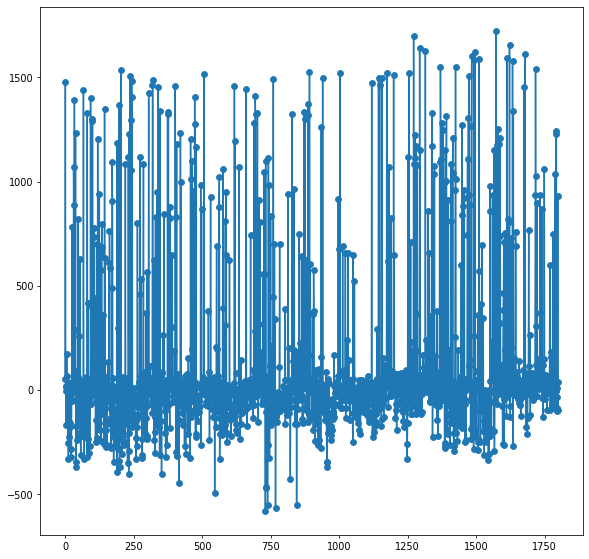

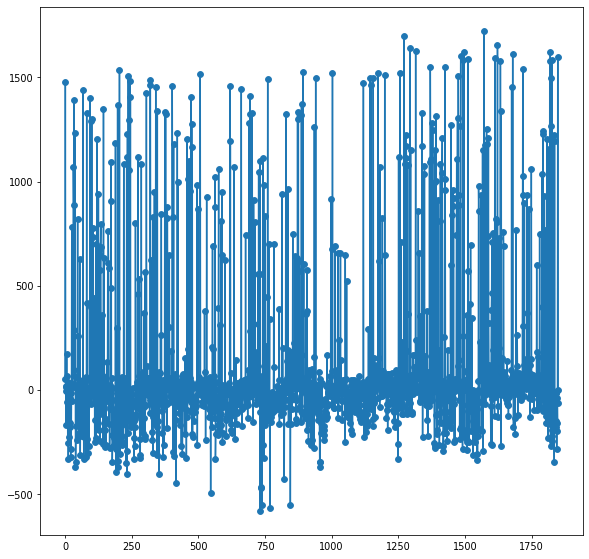

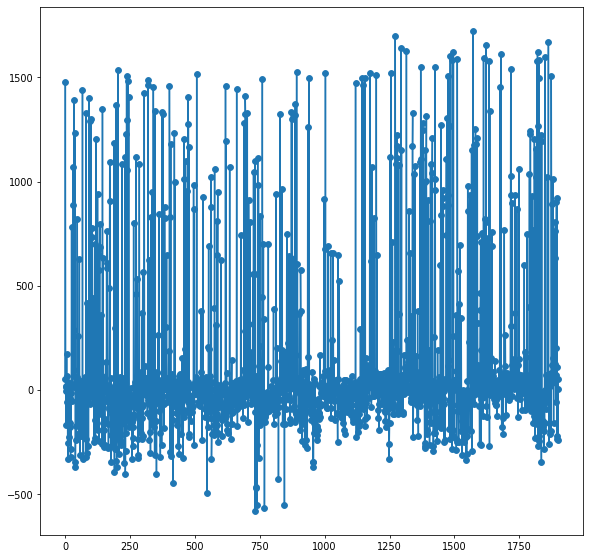

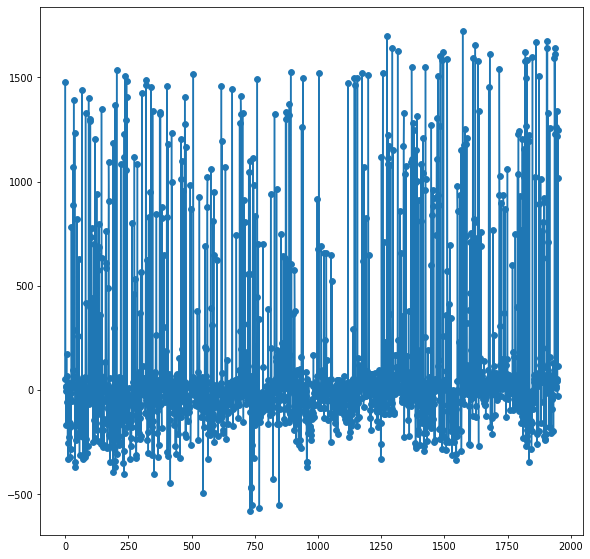

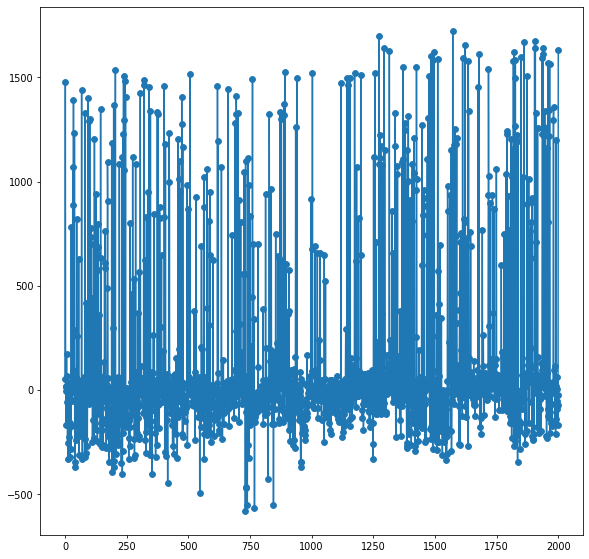

In [7]:
##############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                                             # 动作取值区间,对称区间，故只取上界
hidden_dim = 512
#lr_a = 0.001
#lr_c = 0.001
ddpg = DDPG(a_dim, s_dim, a_bound, hidden_dim)

if LOAD_MODEL:
    ddpg.load_model()

    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.load_pretrain()


if LOAD_MODEL or LOAD_MEM:
    var = 0.1

if LOAD_PRETRAIN:
    var = 0.2

list = [1, 2, 7, 8, 9, 11, 14, 18, 33]
t1 = time.time()                                        # 开始时间

for i in range(MAX_EPISODES):
    LEVEL = random.choice(list)
    s = env.reset(level = LEVEL)
    #s = env.reset(level = int(random.choice([1,2,7,8,9])))
    ep_reward = 0
    
    #if i > 500:
        
     #   if lr_a >= 0.000001:
      #      lr_a = lr_a - 0.0000001
       # if lr_c >= 0.000001:
        #    lr_c = lr_c - 0.0000001
    
    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration

        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        
        if info_.get('success'):
            print('SUCCESS')
            ddpg.Record_success(i)
            r += 100 #+200
        
        r += 10
        r = r * 200
        r+= 200
        r += info.get('qpos') * 4000
        #print(r)
        ddpg.store_transition(s, a, r, s_)         # 为什么要对reward归一化
    
        
        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                var *= .9995                            # 学习阶段逐渐降低动作随机性decay the action randomness
            ddpg.learn()                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS -1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward/j), 'Explore: %.2f' % var, )
            
            ddpg.store_reward(ep_reward/j)
            
            #if ddpg.pointer > ddpg.memory_capacity and done:
                #RENDER = True
            if (i % CHECK_POINT_EPI) == 0 and i != 0:
                ddpg.save('level_9_4000+2000/' + str(i) + 'epi')
            
            break
               
print('Running time: ', time.time() - t1)

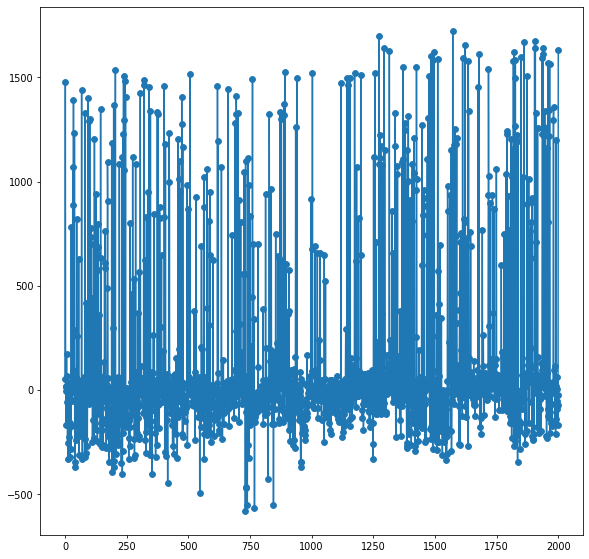

In [8]:
ddpg.save('carbinet_SELF_level_9_4000+2000EPS')

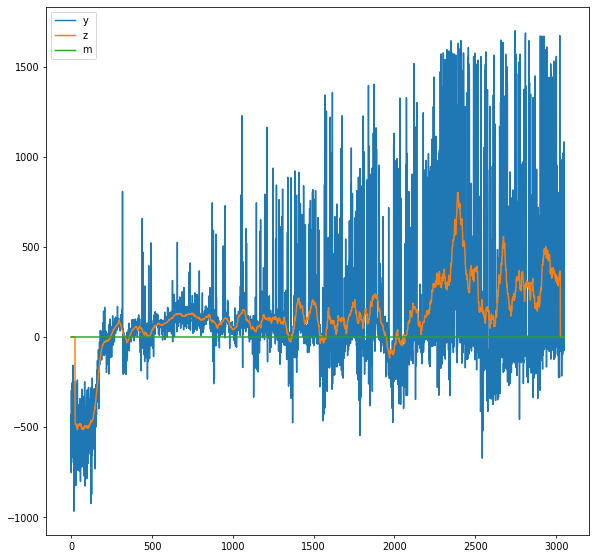

maximum success rate:  0.0
maximum mean rewards:  800.5924504191495


In [8]:
data = pd.read_csv('./DPG model/level12789_check_point_final/3050epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])

size = 50

z = np.zeros(len(y))
m = np.zeros(len(y))

#for i in range(len(y)):
#    if y[i] >= 10:
#        y[i] = 0
        
for i in range(len(y)):
    
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward
            
            if(y[i + j - int(size/2)] == 0):
                m[i] += 1                  #success rate
            
                                   
            
        z[i] = z[i] / size
        m[i] = m[i]
        

    
    
plt.figure(figsize=(10, 10), dpi=70)

plt.plot(x, y)
plt.plot(x, z)
plt.plot(x, m)

plt.legend(['y','z','m'])
plt.show()

print('maximum success rate: ', max(m)/50)
print('maximum mean rewards: ', max(z))

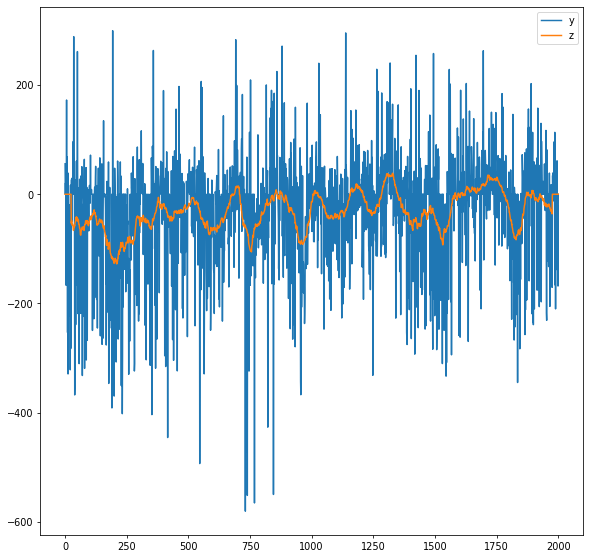

maximum mean rewards:  1328


In [11]:
data = pd.read_csv('./DPG model/level_9_4000+2000/2000epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])
size = 50
z = np.zeros(len(y))
for i in range(len(y)):
    if y[i] >= 300:
        y[i] = 0  
for i in range(len(y)):
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward        
    z[i] = z[i]/size
plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, y)
plt.plot(x, z)
plt.legend(['y','z'])
plt.show()
print('maximum mean rewards: ', np.argmax(z))

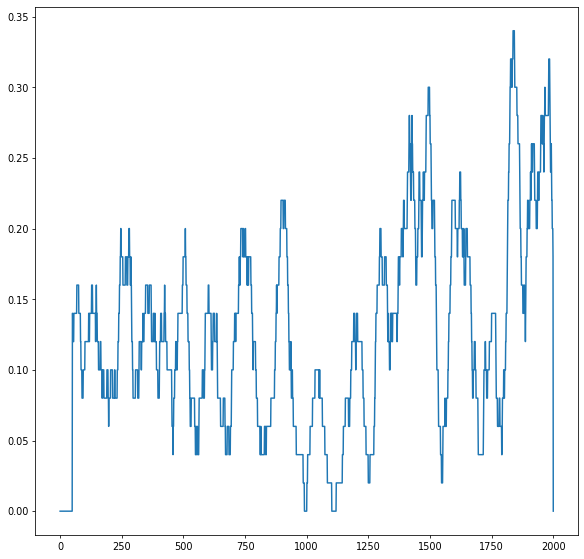

0.34
1837


In [12]:
data = pd.read_csv('./DPG model/level_9_4000+2000/2000epi/Success_record.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])
m = np.zeros(y.shape[0])

for i in range(50,2000):
    for j in range(50):
        if y[i-50+j] == 1:
            m[i] += 1
    m[i] = m[i] / 50   
    
plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, m)
plt.show()
print(max(m))#最大值
print(np.argmax(m))#最大值所在位置